## Gather data, turn markup into vectors and check its correctness

Download Dataset

In [4]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz &> /dev/null
!tar -xvf train-clean-100.tar.gz &> /dev/null && rm train-clean-100.tar.gz

Download Markup

In [5]:
!gdown --id 1G7O_QeKXK-gBmg-9u6B3LezXipCSSsiN
!unzip train-clean-100.zip &> /dev/null
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1G7O_QeKXK-gBmg-9u6B3LezXipCSSsiN
To: /content/train-clean-100.zip
100% 6.10M/6.10M [00:00<00:00, 169MB/s]


In [6]:
import os
import re
import numpy as np
import torch
import torchaudio
from tqdm import tqdm
from IPython.utils import io
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Gather all the available alignments

In [7]:
train_label_path = 'train-clean-100/'

train_label_files = []
for root, _, files in os.walk(train_label_path):
    train_label_files.extend([os.path.join(root, file) for file in files if '.txt' in file])

Create a dict where key is speaker id and value is audio filename and a string with words and their pronounciation times

In [8]:
train_data = dict()

for file in train_label_files:
    key = re.findall('\d+-\d+', file)[0]

    label_lines = data=open(file, 'r').readlines()
    n_input_files = len(label_lines)

    indices = list(map(lambda x: x.split(' ')[0], label_lines))
    base_input_path = os.path.join('LibriSpeech', re.findall('\w+-\w+-\w+/\d+/\d+', file)[0])
    input_files = list(map(lambda x: os.path.join(base_input_path, f'{x}.flac'), indices))

    train_data[key] = {'input': tuple(sorted(input_files)),
                       'label': tuple(sorted(label_lines))}

A function to turn a string into a vector of labels.
<br>Sometimes the rounding may create an array with bigger size than intended so we cut it by N = audio_len_in_ms / 10.
<br>It happens rarely so it is not crucial for evaluation, but learning process crash due to array mismatch is unpeasant so I did what i had to.

In [9]:
def process_label(input, label):
    words_and_pauses = label.split(' ')[1]
    classify = lambda x: 0 if (x == '"' or x == '') else 1
    words_and_pauses = [classify(token) for token in words_and_pauses.split(',')]

    time_intervals = label.split(' ')[2]
    time_intervals = time_intervals.replace('"', '')
    n_time_from_start = [0] + [round(float(interval) * 100) for interval in time_intervals.split(',')]
    n_intervals_from_start = [n_time_from_start[i + 1] - n_time_from_start[i] for i in range(len(n_time_from_start) - 1)]
    
    label_vector = [torch.tensor([class_label] * interval) for class_label, interval in zip(words_and_pauses, n_intervals_from_start)]
    N = int(len(input) / sample_rate * 1000 / 10)

    return torch.cat(label_vector)[:N]

Lets plot that labels that we created to check adequacy of alignment

In [10]:
sample_rate = 16000
pairs = list(zip(train_data[key]['input'], train_data[key]['label']))
filename = pairs[1][0]
waveform, sample_rate = torchaudio.load(filename)
mask = process_label(waveform.squeeze(), pairs[1][1])

In [11]:
plt.rcParams["figure.figsize"] = (20, 12)

def draw_mask(mask, amplitude):
    mask = torch.tensor(mask, dtype=torch.int16)
    ### upper side of plot
    plt.plot(torch.arange(len(mask)) * 160, mask * amplitude, color='lightgreen')
    plt.fill_between(torch.arange(len(mask)) * 160, amplitude, mask * amplitude, facecolor='red', alpha=0.3)
    plt.fill_between(torch.arange(len(mask)) * 160, 0, mask * amplitude, facecolor='lightgreen', alpha=0.3)
    ### lower side of plot
    plt.plot(torch.arange(len(mask)) * 160, -mask * amplitude, color='lightgreen')
    plt.fill_between(torch.arange(len(mask)) * 160, -amplitude, -mask * amplitude, facecolor='red', alpha=0.3)
    plt.fill_between(torch.arange(len(mask)) * 160, 0, -mask * amplitude, facecolor='lightgreen', alpha=0.3)

def draw_waveform(waveform):
    plt.plot(torch.arange(len(waveform.squeeze())), waveform.squeeze(), color='blue')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


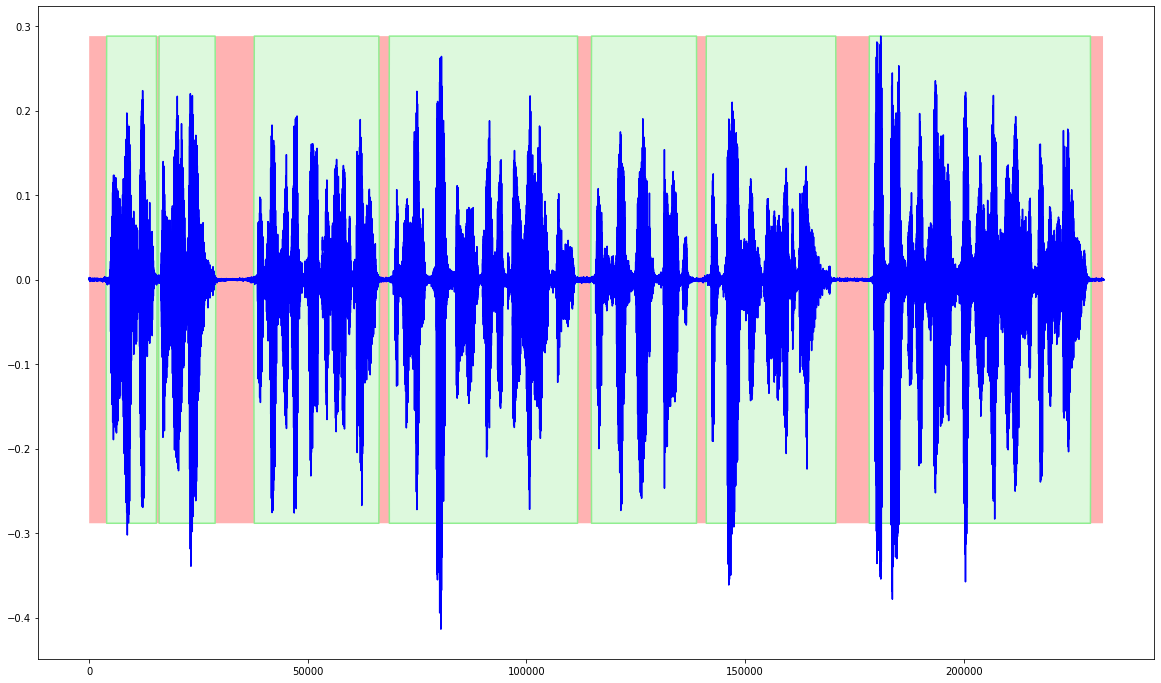

In [12]:
draw_mask(mask, max(waveform.squeeze()))
draw_waveform(waveform)
plt.show()

## Create dataloader from gathered data

split signal in chunks of 10ms size

In [13]:
def split_signal(signal, format='tensor', sample_rate=16000, duration=10):
    N = int(len(signal) / sample_rate * 1000 / duration)
    chunk_size = int(sample_rate * 10 / 1000)
    splitted_signal = [signal[i*chunk_size: (i+1)*chunk_size] for i in range(N)]
    if format == 'uint_16_bytes':
        to_16_bit = lambda x: torch.tensor(x * 2**15, dtype=torch.int16)
        splitted_signal = [to_16_bit(chunk).numpy().tobytes() for chunk in splitted_signal]
    return splitted_signal

In [56]:
class LibriSpeechDataset(Dataset):
    def __init__(self, train_data, window_size=2):
        self.window_size = window_size

        self.inputs = []
        self.labels = []
        for value in train_data.values():
            self.inputs.extend(value['input'])
            self.labels.extend(value['label'])

    def __getitem__(self, item):
        input, _ = torchaudio.load(self.inputs[item])
        input = input.flatten()
        hmm_input = input
        
        splitted_signal = split_signal(input)
        webrtc_input = split_signal(input, 'uint_16_bytes')
        
        padding_chunk = torch.zeros(sample_rate // 100)
        padding = [padding_chunk for _ in range(self.window_size)]
        splitted_signal = padding + splitted_signal + padding
        chunks = []
        for idx in range(self.window_size, len(splitted_signal) - self.window_size):
            chunks.append(torch.cat(splitted_signal[idx - self.window_size: idx + (self.window_size + 1)]))
        batch = torch.stack(chunks)
        batch = torch.cat([
            batch,
            torch.view_as_real(torch.fft.fft(batch))[:, :, 0],
            torch.view_as_real(torch.fft.fft(batch))[:, :, 1]
        ], dim=-1)
        batch = torch.tensor(batch, dtype=torch.float)
        model_input = batch

        label = process_label(input, self.labels[item]).flatten()
        label = torch.tensor(label, dtype=torch.long)
        
        return {'webrtc_input': webrtc_input, 'hmm_input': hmm_input, 'model_input': model_input, 'label': label}

    def __len__(self):
        return len(self.labels)

keys = list(np.random.permutation(list(train_data.keys())))
train_ds = {key: train_data[key] for key in keys[:int(len(keys) * 0.8)]}
valid_ds = {key: train_data[key] for key in keys[int(len(keys) * 0.8):]}

train_loader = DataLoader(LibriSpeechDataset(train_ds), batch_size=1, shuffle=True)
valid_loader = DataLoader(LibriSpeechDataset(valid_ds), batch_size=1, shuffle=True)

## Lets benchmark WebRTC baseline


In [15]:
# Downloading WebRTC VAD
!pip install webrtcvad

     |████████████████████████████████| 66 kB 2.6 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72416 sha256=dcd0a0ba0e75f62f4bcd0d80b6142346073907a6b52f0ff9b8a4a96e9e16ea1d
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
Successfully built webrtcvad


In [30]:
item = next(iter(valid_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [34]:
import webrtcvad
webrtc_vad = webrtcvad.Vad()
webrtc_vad.set_mode(2)

webrtcvad_score = []
for item in tqdm(valid_loader):
    input, label = item['webrtc_input'], item['label']

    # webrtc progresbars can be annoying at times so lets wrap them with no output context manager
    with io.capture_output() as captured:
        preds = [webrtc_vad.is_speech(chunk[0], sample_rate) for chunk in tqdm(input)]

    webrtcvad_score.append(torch.sum((label == torch.tensor(preds, dtype=torch.int16)))/ len(label))

  0%|          | 0/5442 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1%|          | 67/5442 [00:07<10:38,  8.42it/s]


KeyboardInterrupt: ignored

In [ ]:
np.mean(webrtcvad_score)

0.92463505

## And Hidden Markov Model-based solution

In [ ]:
# Downloading HMM VAD
!git clone https://github.com/eesungkim/Voice_Activity_Detector 

In [ ]:
import sys
sys.path.insert(0, '/home/irkstell/Desktop/VKLab/Voice_Activity_Detector')

In [ ]:
from vad import VAD as hmm_vad

hmm_score = []
for item in tqdm(valid_loader):
    input = item['hmm_input'].squeeze()
    label = item['label'].squeeze()
    preds = hmm_vad(input.squeeze().numpy(), sample_rate)
    preds = torch.tensor([_[0] for _ in preds])
    label = label[:len(preds)] # for some reason the model has some issues with being a bit shorter than length of labels so i am using cheats to compare it. I consider it fine for not the final model.
    hmm_score.append(torch.sum((label == torch.tensor(preds, dtype=torch.int16))) / len(label))

  0%|                                                                                             | 0/28535 [00:00<?, ?it/s]/home/irkstell/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
  2%|█▍                                                                               | 488/28535 [07:40<9:20:05,  1.20s/it]/home/irkstell/Desktop/VKLab/Voice_Activity_Detector/utils/estnoise_ms.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  acb=(1+(sum(p) / sum(pSpectrum_t)-1)**2)**(-1)    # alpha_c-bar(t)  (9)
  2%|█▍                                                                               | 497/28535 [07:49<8:26:37,  1.08s/it]/home/irkstell/Desktop/VKLab/Voice_Activity_Detector/utils/estnoise_ms.py:99: RuntimeWarn

## My model

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class VAD_model(nn.Module):
    def __init__(self):
        super(VAD_model, self).__init__()
        self.hidden_dim = 256
        self.lstm = nn.LSTM(2400, 1024)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, batch):
        lstm_out, (hidden_states, _) = self.lstm(batch)
        input = torch.cat([lstm_out.squeeze(0), hidden_states.squeeze(0)], dim=-1)
        pred = self.classifier(input)
        return pred

# rnn_vad = VAD_model().cuda()

In [42]:
!mkdir weights

In [ ]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_vad.parameters(), lr=0.03)
N_EPOCHS = 65
rnn_vad.train()

for epoch in range(N_EPOCHS):
    for batch in tqdm(train_loader):
        rnn_vad.zero_grad()
        
        probs = rnn_vad(batch['model_input'].cuda())
        loss = loss_fn(probs, batch['label'].squeeze().cuda())
        loss.backward()
        optimizer.step()
        
    torch.save(rnn_vad.state_dict(), f'weights/{epoch}')

  0%|          | 0/23380 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 44%|████▎     | 10212/23380 [16:48<19:48, 11.08it/s]

In [59]:
torch.save(rnn_vad.state_dict(), f'weights/{epoch}')

In [52]:
scores = []

rnn_vad.eval()

for batch in tqdm(valid_loader):
    with torch.no_grad():
        probs = rnn_vad(batch['model_input'].cuda())
        preds = torch.argmax(probs, dim=1)
        score = torch.sum(preds == batch['label'].cuda())/len(preds)
        scores.append(score)

  0%|          | 0/911 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 911/911 [01:33<00:00,  9.77it/s]
